## Homework Regression

### Prepare data set

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-10 09:53:58--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.006s  

2024-10-10 09:53:59 (47.9 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [15]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns # for visualization
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("laptops.csv")

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [8]:
df_eda = df[['ram', 'storage', 'screen', 'final_price']]

In [9]:
df_eda.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


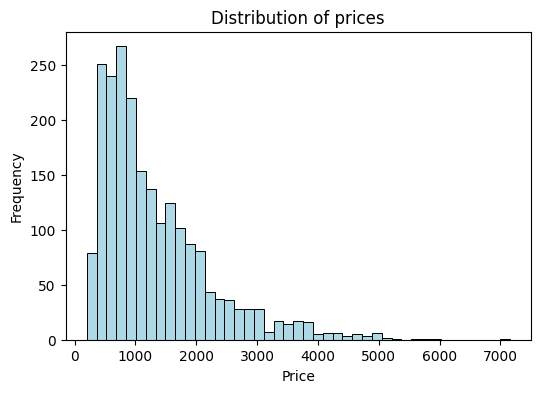

In [16]:
# Look at the median_house_value variable

plt.figure(figsize=(6, 4))
sns.histplot(df_eda.final_price, color='lightblue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

Distribution of the laptop prices has a long tail

### Question 1
There's one column with missing values. What is it?

* `ram`
* `storage`
* __`screen`__
* `final_price`

In [10]:
df_eda.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2
What's the median (50% percentile) for variable 'ram'?

* 8
* __16__
* 24
* 32

In [14]:
df_eda.ram.median()

np.float64(16.0)

### Prepare and split the dataset
* Shuffle the dataset (the filtered one you created above), use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution

In [17]:
# shuffle and split data set
np.random.seed(42)

n = len(df_eda)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_eda.iloc[idx]

df_train = df_eda.iloc[:n_train].copy()
df_val = df_eda.iloc[n_train:n_train+n_val].copy()
df_test = df_eda.iloc[n_train+n_val:].copy()

In [18]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.c.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

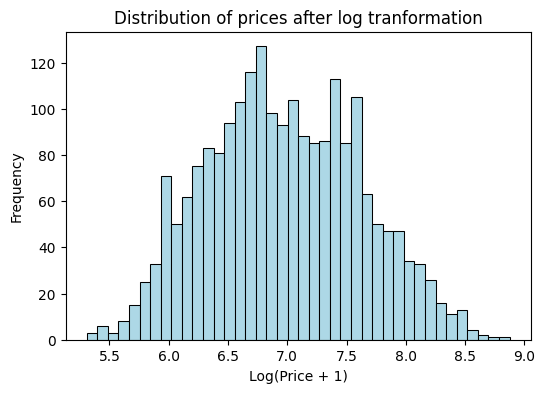

In [19]:
log_price = np.log1p(df_eda.final_price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='lightblue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

By using the log transformation we got rid of the tail and distribution now looks like normal

### Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

* __Options:__

* __With 0__
* With mean
* Both are equally good

In [20]:
# fill NA with 0
df_train_fzero = df_train.copy().fillna(0)
df_val_fzero = df_val.copy().fillna(0)
df_test_fzero = df_test.copy().fillna(0)

In [21]:
# fill NA with mean
mean_tr = df_train.mean()
df_train_fmean = df_train.copy().fillna(mean_tr)
df_val_fmean = df_val.copy().fillna(mean_tr)
df_test_fmean = df_test.copy().fillna(mean_tr)

In [22]:
#Linear Regression function
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [23]:
# weights for model where NAN replaced by 0
w_0_zero, w_zero = train_linear_regression(df_train_fzero, y_train)

In [24]:
# weights for model where NAN replaced by mean value
w_0_mean, w_mean = train_linear_regression(df_train_fmean, y_train)

In [25]:
# calculate prediction using validation data set
y_pred_zero = w_0_zero + df_val_fzero.dot(w_zero)
y_pred_mean = w_0_mean + df_val_fmean.dot(w_mean)

In [26]:
# RMSE
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [28]:
# calculate and compare RMSE
print(round(rmse(y_val, y_pred_zero), 3))
print(round(rmse(y_val, y_pred_mean), 3))

0.544
0.546


A model trained with missing values in column screen replaced with 0 performed slightly better

### Question 4
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

Options:

* __0__
* 0.01
* 1
* 10
* 100

In [29]:
#declare regularisation term
r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [30]:
def prepare_X(df, fill_val):
    #df_num = df[base]
    df_num = df.fillna(fill_val)
    X = df_num.values
    return X

In [31]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [34]:
for r in r_list:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    print(r, w0, score)
    print(r, round(score, 10))
    print('---------')

0 6.49686677431837 0.5439064341048857
0 0.5439064341
---------
1e-06 6.49686596922992 0.5439064450460657
1e-06 0.543906445
---------
0.0001 6.49678626641219 0.5439075282977553
0.0001 0.5439075283
---------
0.001 6.496061785415494 0.5439173823422335
0.001 0.5439173823
---------
0.01 6.488825889976976 0.5440165455570549
0.01 0.5440165456
---------
0.1 6.417347442428603 0.5450686366302565
0.1 0.5450686366
---------
1 5.780878632018807 0.5601059328035921
1 0.5601059328
---------
5 4.015429623036539 0.6482333247313102
5 0.6482333247
---------
10 2.9098393266207916 0.7294642443566978
10 0.7294642444
---------


### Question 5
We used seed `42` for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
For each seed, do the train/validation/test split with `60%/20%/20%` distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
What's the value of std?

* __19.176__
* 29.176
* 39.176
* 49.176

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [35]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [44]:
df = pd.read_csv('laptops.csv')

In [45]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [46]:
df_sliced = df[['ram', 'storage', 'screen', 'final_price']]

In [47]:
df_sliced = df_sliced.copy().fillna(0)

In [48]:
n = len(df_sliced)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
print(n, n_train, n_val, n_test, n_train+n_val+n_test)

2160 1296 432 432 2160


In [49]:
idx = np.arange(n)

In [50]:
scores = []
for s in seed_list:
    np.randomseed = s
    np.random.shuffle(idx)

    df_train = df_sliced.iloc[idx[: n_train]]
    df_val = df_sliced.iloc[idx[n_train : n_train + n_val]]
    df_test = df_sliced.iloc[idx[n_train + n_val : ]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train['final_price'])
    y_val = np.log1p(df_val['final_price'])
    y_test = np.log1p(df_test['final_price'])

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    scores.append(score)
print(scores) 

[np.float64(0.46053101771054356), np.float64(0.43984665208130885), np.float64(0.4601121650512623), np.float64(0.4454710110161262), np.float64(0.46612143054495997), np.float64(0.4040918454066679), np.float64(0.424085065332051), np.float64(0.43858106685689047), np.float64(0.4500699408045841), np.float64(0.44193111760316806)]


In [51]:
std_scores = np.std(scores)
round(std_scores, 3)

np.float64(0.018)

### Question 6
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

Options:

* __598.60__
* 608.60
* 618.60
* 628.60

In [52]:
df = pd.read_csv('laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df_sliced = df[['ram', 'storage', 'screen', 'final_price']]
df_sliced = df_sliced.copy().fillna(0)

In [54]:
n = len(df_sliced)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
print(n, n_train, n_val, n_test)

np.randomseed = 9
np.random.shuffle(idx)


df_train = df_sliced.iloc[idx[: n_train]]
df_val = df_sliced.iloc[idx[n_train : n_train + n_val]]
df_test = df_sliced.iloc[idx[n_train + n_val : ]]
    
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
    
y_train = np.log1p(df_train['final_price'])
y_val = np.log1p(df_val['final_price'])
y_test = np.log1p(df_test['final_price'])

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

2160 1296 432 432


In [55]:
# combine train and validation data sets

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

y_full_train = np.concatenate([y_train, y_val])

In [56]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [57]:
X_full_train = prepare_X(df_full_train, 0)
X_full_train

array([[   8. ,  512. ,   15.6],
       [  16. ,  512. ,   14. ],
       [  16. ,  512. ,   15.6],
       ...,
       [   8. ,  512. ,   15.6],
       [   8. ,  256. ,   13.3],
       [  16. , 1000. ,   15.6]])

In [58]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [59]:
print(w0, w)

6.735212900562788 [ 0.0265334   0.00071881 -0.04071196]


In [60]:
df_test.fillna(0)

,ram,storage,screen
0,8,128,10.5
1,40,1000,14.0
2,16,512,15.6
3,16,1000,14.2
4,16,1000,15.6
...,...,...,...
427,16,1000,15.6
428,8,512,15.6
429,16,512,15.6
430,32,2000,16.0


In [61]:
X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)

rmse(y_test, y_pred)

np.float64(0.44644512370169964)